<a href="https://colab.research.google.com/github/tpeat/titanic-ml/blob/main/titanic_MOGP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline
# Pandas is a nice utilitiy that enables some easy data manipulation, especially from a csv

!pip3 install pandas
import pandas as pd
# Numpy lets us work with arrays
import numpy as np

# Sklearn provides various modules with a common API
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate

!pip install deap
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

import random
import operator
import itertools

# import pickle
import pickle
# turn off warnings
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

Populating the interactive namespace from numpy and matplotlib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 5.2 MB/s 


In [2]:
# Read in our csv files downloaded from Kaggle
train_data = pd.read_csv('processed_train.csv').set_index("PassengerId")
test_data = pd.read_csv('processed_test.csv').set_index("PassengerId")

df = pd.concat([train_data, test_data], axis=0, sort=False)

In [3]:
# We can use .head() to get just the first few rows of the data.
train_data.head()
# Note how the notebook nicely displays the output for us

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,LastName,IsWomanOrBoy,WomanOrBoyCount,FamilySurvivedCount,WomanOrBoySurvived,Alone,Single,SmallF,MedF,LargeF,Deck
PassengerId,,,,,,,,,,,,,,,,,,,,
1,0.0,3,1,22.0,1,0,7.2500,2,10,100,0,0,0.0,0.0,1,0,1,0,0,7
2,1.0,1,0,38.0,1,0,71.2833,0,11,182,1,1,1.0,1.0,0,0,1,0,0,2
3,1.0,3,0,26.0,0,0,7.9250,2,9,329,1,1,1.0,1.0,0,1,0,0,0,7
4,1.0,1,0,35.0,1,0,53.1000,2,11,267,1,1,1.0,1.0,0,0,1,0,0,2
5,0.0,3,1,35.0,0,0,8.0500,2,10,15,0,1,1.0,1.0,0,1,0,0,0,7


## Generate valuable constants from df

In [4]:
# average age
mean_age = df.Age.mean()

# 1st quartile
q1_age = np.quantile(df.Age, 0.25)
# quartile 3
q3_age = np.quantile(df.Age, 0.75)


# mode of passenger class
mode_class = df.Pclass.value_counts().idxmax()

# mode siblings
mode_sibs = df.SibSp.value_counts().idxmax()

# mode parnets
mode_parents = df.Parch.value_counts().idxmax()

# mean fare price
mean_fare = df.Fare.mean()

In [5]:
RANDOM_SEED=10
X_train = train_data.loc[:, train_data.columns != 'Survived']
y_train = train_data.loc[:, 'Survived']
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=RANDOM_SEED)

In [6]:
# create fitness for MO: FP and FN
creator.create("FitnessMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [7]:
# helper functions for primitives
def divide_by_zero(a, b):
    if b == 0:
        return 0
    else:
        return a / b
def if_then_else(input, output1, output2):
    if input: 
        return output1
    else: 
        return output2

def float_to_bool(f):
    return f > 0

In [14]:
# create primitive set
random.seed(25)
pset = gp.PrimitiveSetTyped("main", itertools.repeat(float, 19), bool) 

pset.addPrimitive(operator.add, [float, float], float)
pset.addPrimitive(operator.sub, [float, float], float)
pset.addPrimitive(operator.mul, [float, float], float)
pset.addPrimitive(divide_by_zero, [float, float], float)

pset.addPrimitive(operator.and_, [bool, bool], bool)
pset.addPrimitive(operator.or_, [bool, bool], bool)
pset.addPrimitive(operator.not_, [bool], bool)
pset.addPrimitive(operator.xor, [bool, bool], bool)
pset.addPrimitive(float_to_bool, [float], bool)

pset.addPrimitive(operator.lt, [float, float], bool)
pset.addPrimitive(operator.gt, [float, float], bool)
pset.addPrimitive(operator.eq, [float, float], bool)
pset.addPrimitive(if_then_else, [bool, float, float], float)

pset.addTerminal(0, bool)
pset.addTerminal(1, bool)
pset.addTerminal(2.0, float)
pset.addTerminal(mean_age, float)
pset.addTerminal(q1_age, int)
pset.addTerminal(q3_age, int)
pset.addTerminal(mode_sibs, int)
pset.addTerminal(mode_parents, int)
pset.addTerminal(mode_class, int)
pset.addTerminal(mean_fare, float)

pset.renameArguments(ARG0='Pclass', ARG1='Sex', ARG2='Age', ARG3='SibSp', ARG4='Parch', ARG5="Fare", ARG6="Embarked", ARG7="Deck")

In [15]:
# create toolbox
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=10)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [16]:
def eval_function(individual, points, pset):
    func = gp.compile(expr=individual, pset=pset)
    results = [func(*points[x]) for x in range(len(points))]
    tn, fp, fn, tp = confusion_matrix(y_train, results).ravel()
    return fp/(tn + fp), fn/(tp + fn)

In [17]:
toolbox.register("evaluate", eval_function, points=X_train.values, pset=pset)
toolbox.register("select", tools.selNSGA2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=2, max_=5)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [18]:
expr = gp.genFull(pset, min_=1, max_=5)
tree = gp.PrimitiveTree(expr)
print(str(tree))
print(str(eval_function(tree, X_train.values, pset)))

and_(xor(float_to_bool(divide_by_zero(Sex, ARG8)), and_(float_to_bool(ARG18), gt(SibSp, ARG18))), or_(xor(lt(Fare, ARG17), lt(ARG16, ARG15)), or_(or_(1, 1), lt(Embarked, 33.2760436210848))))
(0.8491620111731844, 0.6680672268907563)


In [19]:
def pareto_dominance(ind1, ind2):
    not_equal = False
    for value_1, value_2 in zip(ind1.fitness.values, ind2.fitness.values):
        if value_1 > value_2:
            return False
        elif value_1 < value_2:
            not_equal = True
    return not_equal

In [20]:
population = toolbox.population(n=300)

In [21]:
fitnesses = list(map(toolbox.evaluate, population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

a_given_individual = toolbox.population(n=1)[0]
a_given_individual.fitness.values = toolbox.evaluate(a_given_individual)

In [22]:
dominated = [ind for ind in population if pareto_dominance(a_given_individual, ind)]
dominators = [ind for ind in population if pareto_dominance(ind, a_given_individual)]
others = [ind for ind in population if not ind in dominated and not ind in dominators]

In [23]:
print(len(dominated))
print((dominators[1].fitness.values[1]))
print(len(others))


2
0.0
294


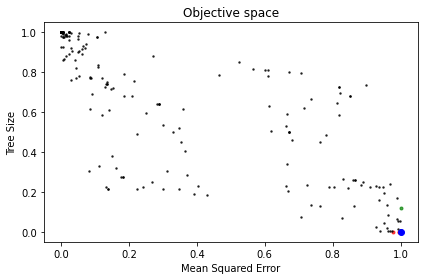

In [24]:
for ind in dominators: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'r.', alpha=0.7)
for ind in dominated: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'g.', alpha=0.7)
for ind in others: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', alpha=0.7, ms=3)
plt.plot(a_given_individual.fitness.values[0], a_given_individual.fitness.values[1], 'bo', ms=6);
plt.xlabel('Mean Squared Error');plt.ylabel('Tree Size');
plt.title('Objective space');
plt.tight_layout()
plt.show()

In [25]:
ngen = 80
cxpb = 0.5
mutpb = 0.1
hof = tools.ParetoFront()

avg_list = []
max_list = []
min_list = []

best_ind = tools.selBest(population, 1)[0]
gen_best = 0

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + stats.fields


# Evaluate the individuals with an invalid fitness
invalid_ind = [ind for ind in population if not ind.fitness.valid]
fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
for ind, fit in zip(invalid_ind, fitnesses):
    ind.fitness.values = fit
    
record = stats.compile(population)
logbook.record(gen=0, nevals=len(invalid_ind), **record)

print(logbook.stream)

for gen in range(1, ngen + 1):
    # Select the next generation individuals
    offspring = toolbox.select(population, len(population))

    # Vary the pool of individuals
    offspring = [toolbox.clone(ind) for ind in population]

    # Apply crossover and mutation on the offspring
    for i in range(1, len(offspring), 2):
        if random.random() < cxpb:
            offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                          offspring[i])
            del offspring[i - 1].fitness.values, offspring[i].fitness.values

    for i in range(len(offspring)):
        if random.random() < mutpb:
            offspring[i], = toolbox.mutate(offspring[i])
            del offspring[i].fitness.values

        # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
    hof.update(offspring)
    
    if sum(tools.selBest(population, 1)[0].fitness.values) < sum(best_ind.fitness.values):
        best_ind = tools.selBest(population, 1)[0]
        gen_best = gen

        # Replace the current population by the offspring
    population[:] = offspring
    
    record = stats.compile(population) if stats else {}
    logbook.record(gen=gen, nevals=len(invalid_ind), **record)
    
    print(logbook.stream)

print("Best individual is %s, %s, from gen %s" % (best_ind, best_ind.fitness.values, gen_best))

gen	nevals	avg                    	std                    	min    	max    
0  	0     	[0.43055866 0.55553221]	[0.42521411 0.40907563]	[0. 0.]	[1. 1.]
1  	151   	[0.42445996 0.57081232]	[0.42270783 0.40542173]	[0. 0.]	[1. 1.]
2  	171   	[0.47116387 0.52988796]	[0.43119076 0.41203731]	[0. 0.]	[1. 1.]
3  	169   	[0.45932961 0.51738095]	[0.42593348 0.4054461 ]	[0. 0.]	[1. 1.]
4  	162   	[0.45276536 0.53026611]	[0.4223292  0.40173682]	[0. 0.]	[1. 1.]
5  	153   	[0.45077281 0.52927171]	[0.41847057 0.40094336]	[0. 0.]	[1. 1.]
6  	159   	[0.4488175  0.54235294]	[0.4230133  0.40740128]	[0. 0.]	[1. 1.]
7  	167   	[0.44357542 0.54612045]	[0.42452036 0.40693799]	[0. 0.]	[1. 1.]
8  	157   	[0.44226257 0.55718487]	[0.42361101 0.40410015]	[0. 0.]	[1. 1.]
9  	166   	[0.44197393 0.55330532]	[0.42921618 0.41316549]	[0. 0.]	[1. 1.]
10 	176   	[0.45097765 0.55012605]	[0.42595534 0.40913235]	[0. 0.]	[1. 1.]
11 	181   	[0.42503724 0.5642437 ]	[0.42522864 0.40917293]	[0. 0.]	[1. 1.]
12 	168   	[0.4466108  0.

Best individual is: gt(divide_by_zero(if_then_else(float_to_bool(if_then_else(not_(0), if_then_else(1, Pclass, Sex), add(Deck, ARG15))), if_then_else(and_(gt(ARG14, ARG10), not_(0)), mul(if_then_else(0, ARG14, ARG13), add(29.26483575248281, ARG18)), if_then_else(float_to_bool(divide_by_zero(Parch, sub(33.2760436210848, 29.26483575248281))), if_then_else(1, ARG9, Fare), sub(ARG15, ARG9))), mul(if_then_else(xor(1, 0), add(Embarked, ARG11), if_then_else(0, Deck, Parch)), divide_by_zero(if_then_else(1, Embarked, ARG8), divide_by_zero(ARG8, ARG14)))), if_then_else(lt(sub(add(mul(divide_by_zero(divide_by_zero(ARG11, SibSp), divide_by_zero(Age, ARG18)), if_then_else(not_(float_to_bool(add(ARG11, Pclass))), sub(Embarked, ARG14), divide_by_zero(ARG17, ARG11))), Sex), add(sub(mul(sub(ARG12, ARG13), mul(ARG10, 33.2760436210848)), divide_by_zero(if_then_else(0, ARG18, 2.0), add(ARG12, ARG8))), add(add(mul(add(sub(Sex, ARG17), divide_by_zero(ARG8, Sex)), if_then_else(lt(Parch, ARG13), divide_by_zer

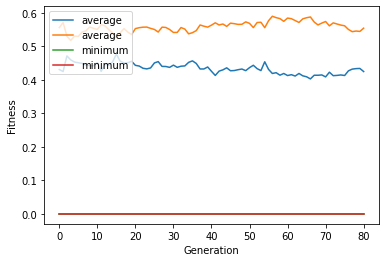

In [26]:
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
gen, avg, min_, max_ = logbook.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="upper left")
plt.show()

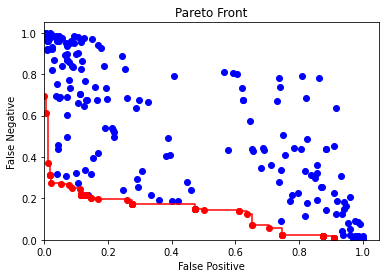

Area Under Curve: 0.1372118679874184


In [27]:
"""Split fitness values into separate lists"""
fitness_1 = [ind.fitness.values[0] for ind in hof]
fitness_2 = [ind.fitness.values[1] for ind in hof]
pop_1 = [ind.fitness.values[0] for ind in population]
pop_2 = [ind.fitness.values[1] for ind in population]

'''Print dominated population for debugging'''
# for ind in pop:
#     print(ind.fitness)

plt.scatter(pop_1, pop_2, color='b')
plt.scatter(fitness_1, fitness_2, color='r')
plt.plot(fitness_1, fitness_2, color='r', drawstyle='steps-post')
plt.xlabel("False Positive")
plt.ylabel("False Negative")
plt.title("Pareto Front")
plt.ylim(bottom=0.0)
plt.xlim(left=0.0)
plt.show()

f1 = np.array(fitness_1)
f2 = np.array(fitness_2)

"""Calculate area under curve with least squares method"""
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(f1))*f2[:-1])))

In [28]:
predictions = [ind for ind in hof]    

In [29]:
test_df = pd.read_csv("clean_test_data.csv", index_col = "PassengerId")
test_df.head()

FileNotFoundError: ignored

In [ ]:
def eval_test(points, pset):
    out = pd.DataFrame(index=test_df.index)
    index = 0
    for ind in predictions:
        func = gp.compile(expr=ind, pset=pset)
        results = [func(*points[x]) for x in range(len(points))]
        out[index] = results
        index += 1
    return out

In [ ]:
out = eval_test(test_df.values, pset)
type(out)

In [ ]:
out.shape

In [ ]:
out.to_csv("titanic_deap.csv")